# Caracterização de Partículas
-----------------------------------------

## Definição de Dados Iniciais
---------------------------------------

In [1]:
#BIBLIOTECAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#DADOS
data = {

    "Mesh":["Sem Mesh",12,32,48,60,100,"Fundo"],
    "Diâmetro":[6.3,1.4,0.5,0.3,0.25,0.15,0],
    "Massa Peneira":[478,412,348,404,348,338,336],
    "Massa Total":[578,612,566,604,362,404,340]

}

dataset = pd.DataFrame(data) #Criando Dataset inicial

## Tabela Base
---

Esta tabela, servirá como um

In [2]:
def Base_Table():
    pd.options.display.float_format = '{:,.4f}'.format

    dataset["Massa Solido"] = dataset["Massa Total"] - dataset["Massa Peneira"]
    dataset["Fração Retida"] = dataset["Massa Solido"]/sum(dataset["Massa Solido"])
    dataset["Percentual Retido"] = dataset["Fração Retida"] * 100

    
    dataset["Fração Passante"] = 1 - dataset["Fração Retida"].cumsum()
    dataset["Percentual Passante"] = dataset["Fração Passante"] * 100

    return dataset

In [3]:
def Model_Table():
    model_table = pd.DataFrame()
    
    model_table["Diâmetro"] = dataset["Diâmetro"].iloc[:-1]
    model_table["Fração Passante"] = Base_Table()["Fração Passante"]
    
    model_table["1/(1-Xi)"] = 1/(1 - model_table["Fração Passante"])
    model_table["X/(1-X)"] = model_table["Fração Passante"]/(1 - model_table["Fração Passante"])


    return model_table

In [4]:
def RRB():
    RRB_table = pd.DataFrame()
    
    RRB_table["ln(Di)"] = np.log(Model_Table()["Diâmetro"])
    RRB_table["ln{ln[1/(1-Xi)]}"] = np.log(np.log(Model_Table()["1/(1-Xi)"]))
    
    X_RRB = RRB_table["ln(Di)"].values.reshape(-1, 1)
    Y_RRB = RRB_table["ln{ln[1/(1-Xi)]}"].values

    return {"Table":RRB_table, "X":X_RRB, "Y":Y_RRB}

In [5]:
def GGS():
    GGS_table = pd.DataFrame()
    
    GGS_table["ln(Di)"] = np.log(Model_Table()["Diâmetro"])
    GGS_table["ln(Xi)"] = np.log(Model_Table()["Fração Passante"])
    
    X_GGS = GGS_table["ln(Di)"].values.reshape(-1, 1)
    Y_GGS = GGS_table["ln(Xi)"].values

    return {"Table":GGS_table, "X":X_GGS, "Y":Y_GGS}

In [6]:
def Sigmoide():
    Sig_Table = pd.DataFrame()
    
    Sig_Table["log(Di)"] = np.log10(Model_Table()["Diâmetro"])
    Sig_Table["log(X/(1-X))"] = np.log10(Model_Table()["X/(1-X)"])
    
    X_Sig = Sig_Table["log(Di)"].values.reshape(-1,1)
    Y_Sig = Sig_Table["log(X/(1-X))"].values

    return {"table":Sig_Table, "X":X_Sig, "Y":Y_Sig}

In [7]:
def Regression(X,Y):

    #Treinamento da Máquina
    from sklearn.linear_model import LinearRegression

    regressor = LinearRegression()
    regressor.fit(X, Y)

    #Previsão
    Y_pred = regressor.predict(X)

    #Validação do Modelo
    from sklearn.metrics import r2_score

    r2_score = r2_score(Y, Y_pred)
    
    #return r2_score, Y_pred
    return {"score":r2_score, "prediction":Y_pred}

In [8]:
#SELEÇÃO DO MELHOR MODELO

models = {
    "RRB":RRB(),
    "GGS":GGS(),
    "Sigmoide":Sigmoide()
    }

regressions = {
    "RRB":Regression(RRB()["X"], RRB()["Y"]),
    "GGS":Regression(GGS()["X"], GGS()["Y"]),
    "Sigmoide":Regression(Sigmoide()["X"], Sigmoide()["Y"])
    }

model_labels = {
    "RRB":("ln(Di)", "ln{ln[1/(1-Xi)]}"),
    "GGS":("ln(Di)", "ln(Xi)"),
    "Sigmoide":("log(Di)", "log(X/(1-X))")
    }

best_model = max(dict(zip(models.keys(), [reg["score"] for reg in regressions.values()])))

#x_labels = {"RRB":"ln(Di)","GGS":"ln(Di)","Sigmoide":"log(Di)"}
#y_labels = {"RRB":"ln{ln[1/(1-Xi)]}","GGS":"ln(Xi)","Sigmoide":"log(X/(1-X))"}


In [ ]:
print("TABELA BASE")
display(Base_Table().style.hide())

print(f"MODELO: {best_model}")
print(f"R²: {regressions[best_model]["score"] * 100:.4f} %")
display(models[best_model]["table"].style.hide())

TABELA BASE


Mesh,Diâmetro,Massa Peneira,Massa Total,Massa Solido,Fração Retida,Percentual Retido,Fração Passante,Percentual Passante
Sem Mesh,6.300000,478,578,100,0.124688,12.468828,0.875312,87.531172
12,1.400000,412,612,200,0.249377,24.937656,0.625935,62.593516
32,0.500000,348,566,218,0.271820,27.182045,0.354115,35.411471
48,0.300000,404,604,200,0.249377,24.937656,0.104738,10.473815
60,0.250000,348,362,14,0.017456,1.745636,0.087282,8.728180
100,0.150000,338,404,66,0.082294,8.229426,0.004988,0.498753
Fundo,0.000000,336,340,4,0.004988,0.498753,0.000000,0.000000


MODELO: Sigmoide
R²: 85.3595 %


log(Di),log(X/(1-X))
0.799341,0.846337
0.146128,0.223582
-0.301030,-0.261011
-0.522879,-0.931845
-0.602060,-1.019413
-0.823909,-2.299943


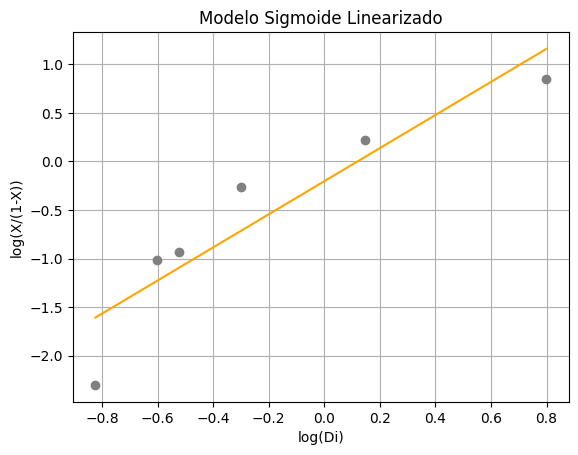

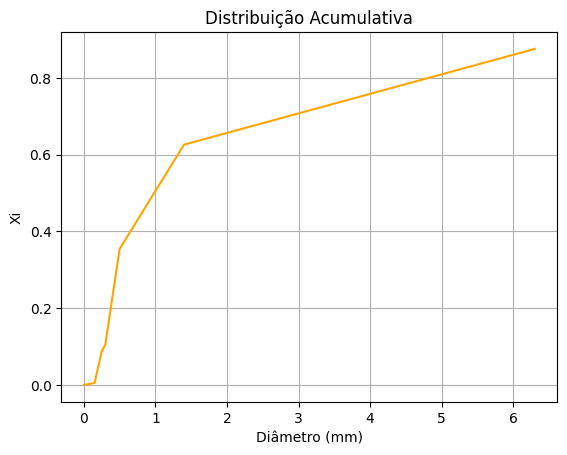

In [ ]:
#GRÁFICOS
#Grafico Modelo
x_axis = models[best_model]["X"]
y_axis = models[best_model]["Y"]
y_reg_axis = regressions[best_model]["prediction"]

plt.scatter(x_axis, y_axis, color="grey",zorder=3)
plt.plot(x_axis, y_reg_axis, color="orange",zorder=4)
plt.title(f"Modelo {best_model} Linearizado")
plt.xlabel(f"{model_labels[best_model][0]}")
plt.ylabel(f"{model_labels[best_model][1]}")
plt.grid(True,zorder=5)
plt.show()

#Grafico Distribuição Cumulativa
x_axis = dataset["Diâmetro"].values
x_axis.sort()

y_axis = Base_Table()["Fração Passante"].values
y_axis.sort()

plt.title("Distribuição Acumulativa")
plt.plot(x_axis, y_axis, color="orange", zorder=4)
plt.xlabel("Diâmetro (mm)")
plt.ylabel("Xi")
plt.grid(True,zorder=3)
plt.show()
